In [10]:
import pandas as pd
from tqdm import tqdm
from PIL import Image
import random
import numpy as np
import os
import socket
from sklearn.model_selection import train_test_split
import keras
from keras.applications.densenet import DenseNet121
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.utils import to_categorical
import urllib2
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)

In [11]:
!ls
img_path = '/media/dudeperf3ct/New Volume/x_ray_image_recognition_data_updated/x_ray_image_recognition_data/x_ray_images/train_xray_images'

Delhivery_Image_Classification.ipynb	replace_and_resize.py  train.csv
product_description_and_categories.csv	test.csv


# Load and Analyse Data

In this step we will load the data using pandas and analyse all the different features of the data.

In [12]:
train_data = pd.read_csv('train.csv')
train_data.head(5)

,x_ray_image_file_name,product_description,x_ray_product_description_match_status
0,1.jpg,Acer Aspire SW3-016 10.1-inch Laptop (Atom x5-...,True
1,2.jpg,Apple iPhone 6S 64 GB (Golden),True
2,4.jpg,"7th ,8th(2) , 1st , 5th",True
3,5.jpg,10th Class,True
4,6.jpg,"4th , 5th & English Class",True


In [13]:
train_data.describe(include='all')

,x_ray_image_file_name,product_description,x_ray_product_description_match_status
count,112962,112960,112962
unique,112962,25917,2
top,43681.jpg,Mobile Phone,True
freq,1,1948,103464


In [14]:
print (train_data.isnull().sum())
print ('... Label Distribution ...')
print (train_data.x_ray_product_description_match_status.value_counts())

x_ray_image_file_name                     0
product_description                       2
x_ray_product_description_match_status    0
dtype: int64
... Label Distribution ...
True     103464
False      9498
Name: x_ray_product_description_match_status, dtype: int64


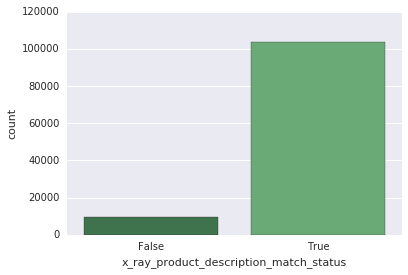

In [15]:
sns.countplot(x="x_ray_product_description_match_status", data=train_data, palette="Greens_d")

In [16]:
 _PIL_INTERPOLATION_METHODS = {
        'nearest': Image.NEAREST,
        'bilinear': Image.BILINEAR,
        'bicubic': Image.BICUBIC,
}
def loadimg(img, target_size=(224, 224), interpolation='nearest'):
    if target_size is not None:
        width_height_tuple = (target_size[1], target_size[0])
    if img.size != width_height_tuple:
        if interpolation not in _PIL_INTERPOLATION_METHODS:
            raise ValueError(
                'Invalid interpolation method {} specified. Supported '
                'methods are {}'.format(
                    interpolation,
                    ", ".join(_PIL_INTERPOLATION_METHODS.keys())))
        resample = _PIL_INTERPOLATION_METHODS[interpolation]
        img = img.resize(width_height_tuple, resample)
    return img

Apple iPhone 6S 64 GB (Golden)
True
(445, 764)


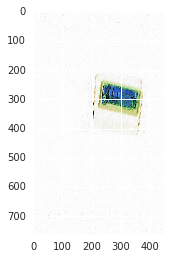

In [17]:
image, product_desc, label = train_data.iloc[1]
img = Image.open(os.path.join(img_path, image))
plt.imshow(img)
print (product_desc)
print (label)
print (img.size)

# img1 = loadimg(img, target_size=(224, 224), interpolation='nearest')
# plt.imshow(img1)
# print (img1.size)

# Data Preprocessing (Not Required)

This step we will remove all the entries from data (rows) which have broken links. Nothing can be done about that!

In [94]:
print (train_data.isnull().sum())

x_ray_image_file_name                     0
product_description                       2
x_ray_product_description_match_status    0
dtype: int64


In [99]:
def preprocess_imgs(images):
    data = []
    for imgs in tqdm(images):
        img = Image.open(os.path.join(img_path, imgs))
        resized_img = loadimg(img, target_size=(224, 224), interpolation='nearest')
        data.append(np.asarray(resized_img))
    return data

In [100]:
num_class = len(train_data.x_ray_product_description_match_status.unique())
x, y = train_data['x_ray_image_file_name'], train_data['x_ray_product_description_match_status']

In [101]:
train_x = preprocess_imgs(x[:1])
lb = LabelEncoder()
train_y = lb.fit_transform(y[:1])
train_x = np.asarray(train_x)
train_y = np.asarray(train_y)
train_y = to_categorical(train_y, num_classes=num_class)
print ('Training set', train_x.shape, train_y.shape)

100%|██████████| 1/1 [00:00<00:00,  9.29it/s]

('Training set', (1, 224, 224, 3), (1, 2))


In [31]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.20)
print ('Training set', train_x.shape, train_y.shape)
print ('Validation set', val_x.shape, val_y.shape)

('Training set', (400, 224, 224, 3), (400, 24))
('Validation set', (100, 224, 224, 3), (100, 24))


# Baseline Model

Get a simple working model for above data. Use a pretrained model e.g. Resnet, VGG16, Inception

In [32]:
def base_model():

    # create the base pre-trained model
    base_model = DenseNet121(weights='imagenet', include_top=False)

    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(num_class, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
 
    return model

In [33]:
model = base_model()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.fit(train_x, train_y, epochs=10, batch_size=32, validation_data=(val_x, val_y))

30023680/30011760 [==============================] - 50s 2us/step
